# Overview:

See this chatGPT conversation https://chatgpt.com/c/6894a24f-1260-832e-9301-6f37cd288fb1

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
## general libraries
import pathlib
from rich.pretty import install
## data handling libraries
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
## machine learning libraries
import gpytorch
## PAMIR libraries
import pamir_mlpermafrost as pamir
install(overflow=True)

In [22]:
config_dir = str(pathlib.Path('../../src/pamir_mlpermafrost/conf').resolve())
config_name = 'laptop-jupyter'

cfg = pamir.utils.load_hydra_config(config_dir, config_name)

# Data Loading

In [23]:
func = cfg.preprocessing.training

In [24]:
# re-define target variable
target = 'permafrost_temperature'

func.keywords['target'] = target
features = func.keywords['features']

In [25]:
data = cfg.data.training.load().loc[(slice(None), slice(40_000, 49_999)),]
data[target] = data[target]
data_X, data_y = cfg.preprocessing.training(data)

train_X, test_X, train_y, test_y = cfg.preprocessing.train_test_split(data_X, data_y)

In [26]:
data['mean_temp_thawed'] = data[['ground_temp_2m', 'ground_temp_5m', 'ground_temp_10m']].pipe(lambda x: x > 0).all(axis=1)
data['aspect_cos'] = np.cos(np.deg2rad(data['aspect']))
data['aspect_sin'] = np.sin(np.deg2rad(data['aspect']))

In [27]:
data.columns


Index(['latitude', 'longitude', 'altitude', 'slope_angle', 'aspect',
       'skyview_factor', 'stratigraphy_index', 'albedo', 'emissivity',
       'roughness_length', 'precip_scaling', 'active_layer_thickness',
       'permafrost_thickness', 'active_layer_temperature',
       'permafrost_temperature', 'ground_temp_2m', 'ground_temp_5m',
       'ground_temp_10m', 'profile', 'land_cover', 'temperature',
       'temperature_downscaled', 'precipitation', 'snow_melt_doy',
       'temp2m_DJF_q05', 'temp2m_JJA_q05', 'temp2m_MAM_q05', 'temp2m_SON_q05',
       'temp2m_DJF_q50', 'temp2m_JJA_q50', 'temp2m_MAM_q50', 'temp2m_SON_q50',
       'temp2m_DJF_q95', 'temp2m_JJA_q95', 'temp2m_MAM_q95', 'temp2m_SON_q95',
       'precip_DJF_q05', 'precip_JJA_q05', 'precip_MAM_q05', 'precip_SON_q05',
       'precip_DJF_q50', 'precip_JJA_q50', 'precip_MAM_q50', 'precip_SON_q50',
       'precip_DJF_q95', 'precip_JJA_q95', 'precip_MAM_q95', 'precip_SON_q95',
       'mean_temp_thawed', 'aspect_cos', 'aspect_sin'

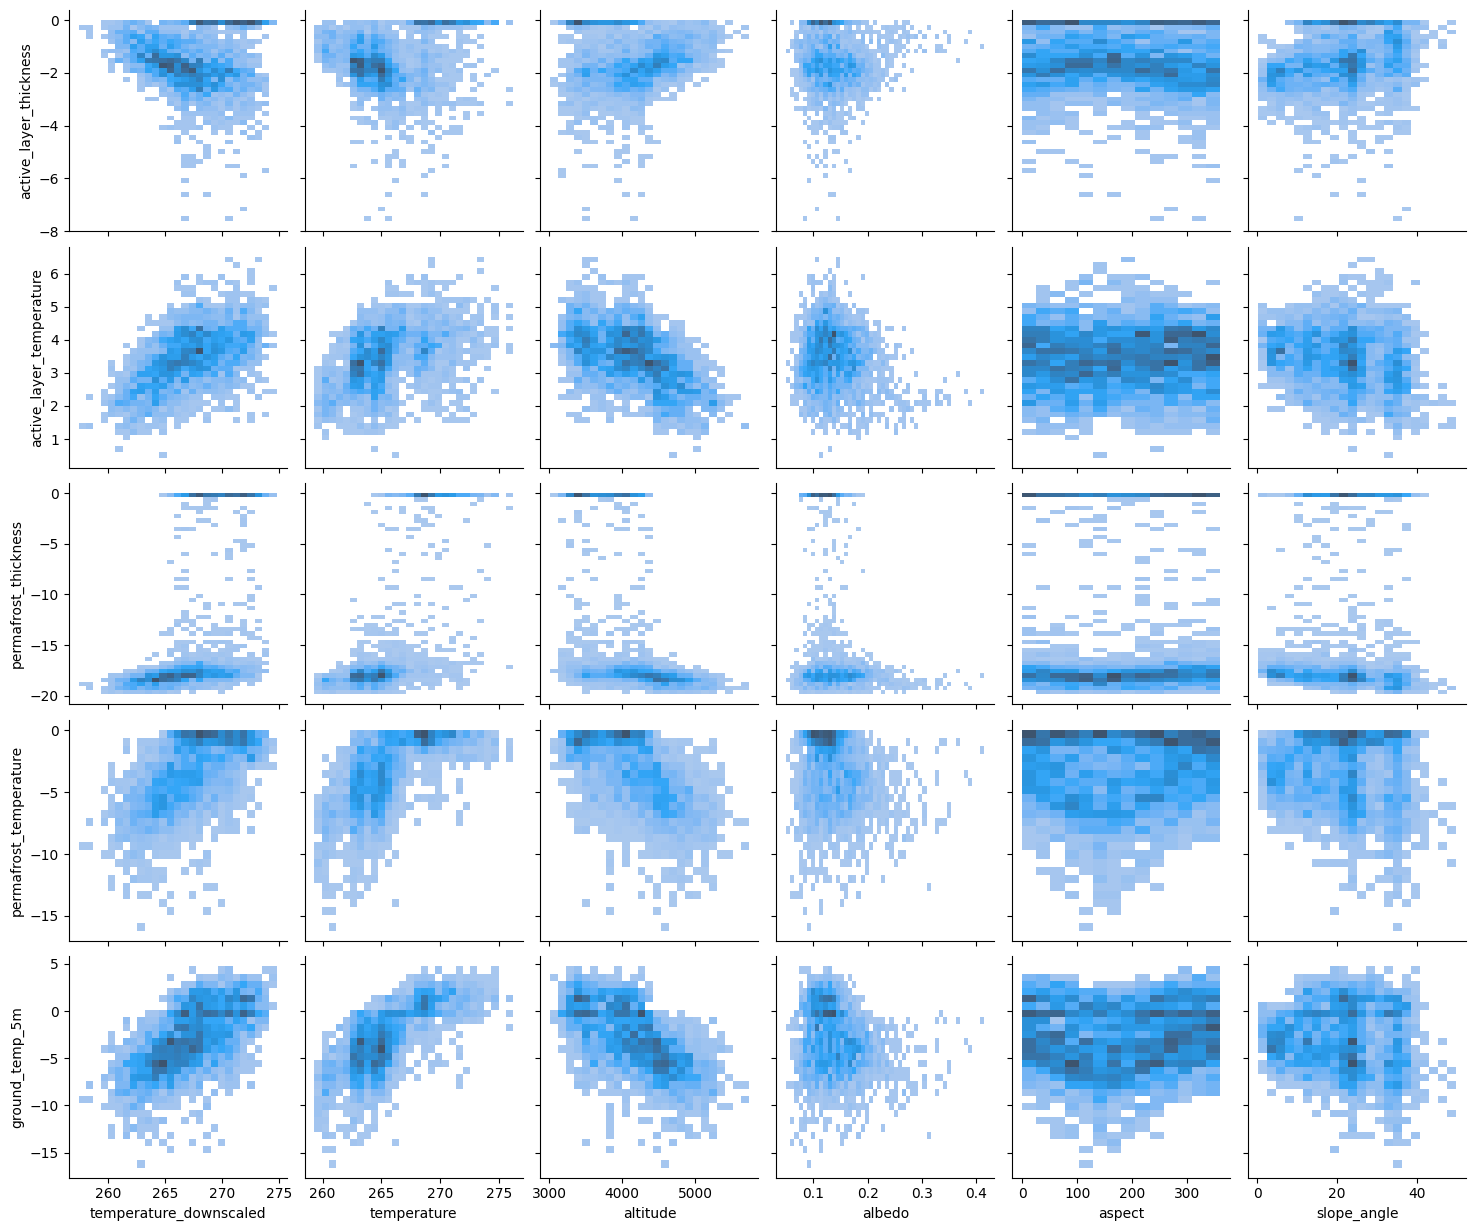

In [28]:
x_vars = [
    'temperature_downscaled',
    'temperature',
    'altitude',
    'albedo',
    'aspect',
    'slope_angle',
]
y_vars = [
    'active_layer_thickness',
    'active_layer_temperature',
    'permafrost_thickness',
    'permafrost_temperature',
    'ground_temp_5m',
]

sns.pairplot(
    data=data,#.where(~data.mean_temp_thawed),
    x_vars=x_vars,
    y_vars=y_vars,
    # hue='mean_temp_thawed',
    kind='hist',
    diag_kind='hist')

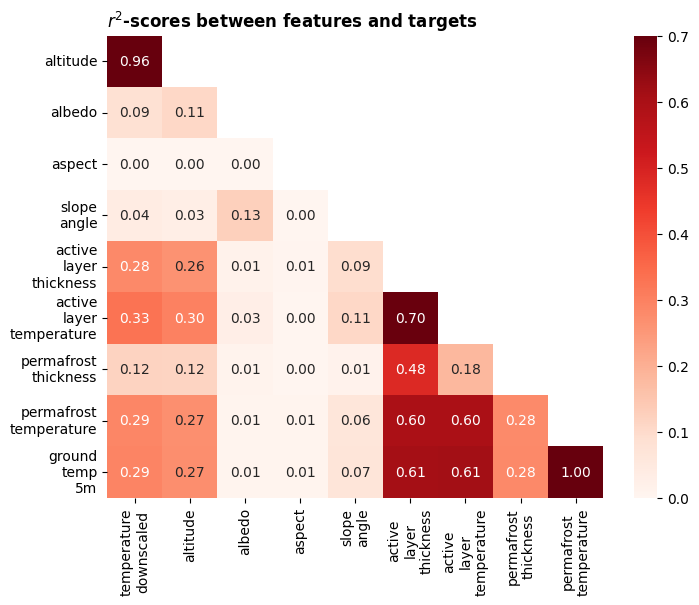

In [10]:
df_xy = (
    data[x_vars + y_vars]
    .where(~data.mean_temp_thawed)
    .dropna()
    .corr(method='pearson')
    .where(lambda x: np.tril(x, -1).astype(bool))
    .rename(
        columns=lambda x: x.replace('_', '\n'),
        index=lambda x: x.replace('_', '\n'))
    .rename_axis(index='', columns='')
    .pipe(lambda x: x**2)
)

fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.heatmap(
    data=df_xy.abs(),
    annot=True,
    fmt='.2f',
    cmap='Reds',
    vmin=0, vmax=0.7,
    square=False,
    ax=ax,
)

n_cols = len(df_xy.columns)
ax.set_ylim([n_cols, 1])
ax.set_xlim([0, n_cols - 1])

ax.set_title('$r^2$-scores between features and targets', loc='left', weight='bold')

plt.show()

# Exploring features

## Ground temperatures

Text(0.0, 1.0, '$\\sigma$ of ground temperatures at [2m, 5m, 10m]')

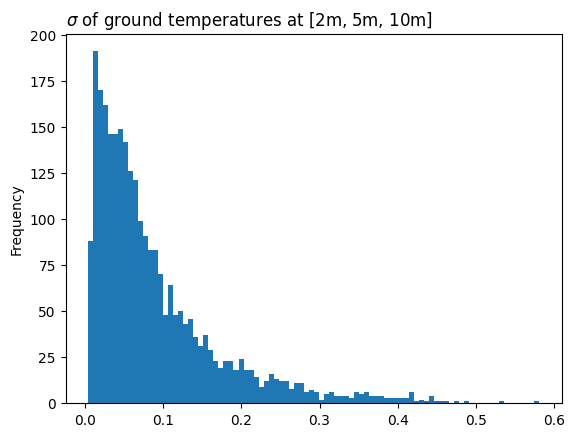

In [11]:
df_ground_temps = data.filter(regex='ground_temp')

ax = df_ground_temps.std(axis=1).plot.hist(bins=90)
ax.set_title('$\\sigma$ of ground temperatures at [2m, 5m, 10m]', loc='left')

In [12]:
vars = [
    'ground_temp_2m',
    'ground_temp_5m',
    'ground_temp_10m',
    'permafrost_temperature',
    'active_layer_temperature',
    'temperature_downscaled',
    'temperature',
    'temp2m_DJF_q05',
    'temp2m_MAM_q05',
    'temp2m_JJA_q05',
    'temp2m_SON_q05',
    'temp2m_DJF_q50',
    'temp2m_MAM_q50',
    'temp2m_JJA_q50',
    'temp2m_SON_q50',
    'temp2m_DJF_q95',
    'temp2m_MAM_q95',
    'temp2m_JJA_q95',
    'temp2m_SON_q95',
]

df_temps = (
    data[vars]
    .dropna()
    .corr(method='pearson')
    # .where(lambda x: np.tril(x, -1).astype(bool))
    .rename(
        columns=lambda x: x.replace('_', '\n'),
        index=lambda x: x.replace('_', '\n'))
    .rename_axis(index='', columns='')
    .pipe(lambda x: x**2)
    .iloc[:5, 5:]
)

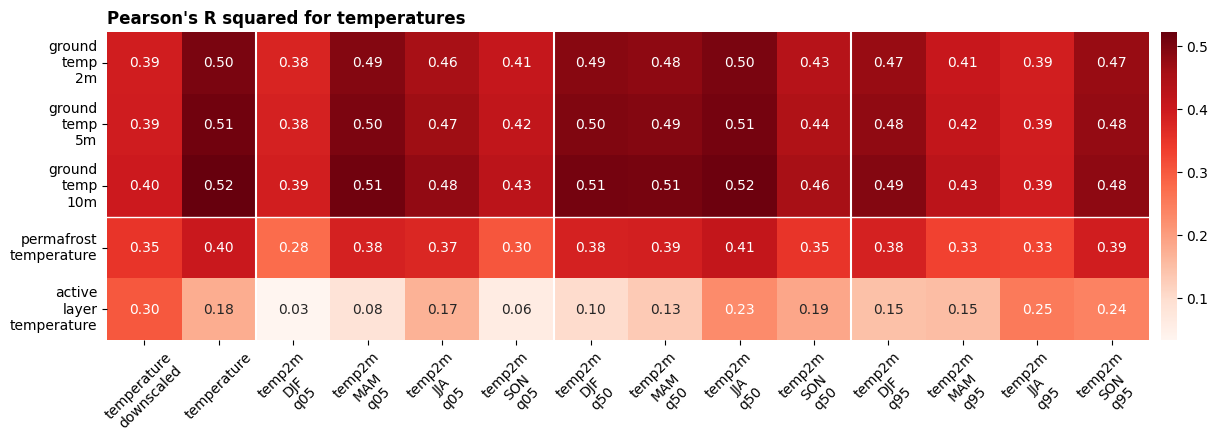

In [13]:
fig, ax = plt.subplots(figsize=(16, 4))

ax = sns.heatmap(
    data=df_temps,
    annot=True,
    fmt='.2f',
    cmap='Reds',
    ax=ax,
    cbar_kws={'pad': 0.01}
)

ax.vlines([2, 6, 10], *ax.get_ylim(), color='white')
ax.axhline(3, color='white', lw=1)

ax.set_title("Pearson's R squared for temperatures", loc='left', weight='bold')
plt.xticks(rotation=45, ha='center')
plt.show()

# Precipitation

In [14]:
vars = [
    'ground_temp_2m',
    'ground_temp_5m',
    'ground_temp_10m',
    'permafrost_temperature',
    'active_layer_temperature',
    'temperature',
    'precipitation',
    'precip_DJF_q50',
    'precip_MAM_q50',
    'precip_JJA_q50',
    'precip_SON_q50',
    'precip_DJF_q95',
    'precip_MAM_q95',
    'precip_JJA_q95',
    'precip_SON_q95',
]

df_precip = (
    data[vars]
    .dropna()
    .corr(method='spearman')
    # .where(lambda x: np.tril(x, -1).astype(bool))
    .rename(
        columns=lambda x: x.replace('_', '\n'),
        index=lambda x: x.replace('_', '\n'))
    .rename_axis(index='', columns='')
    .pipe(lambda x: x**2)
    .iloc[:5, 5:]
)

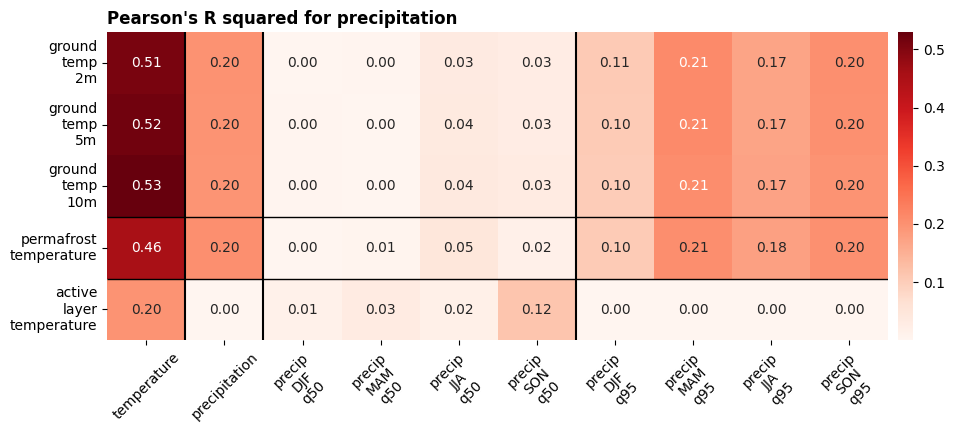

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))

ax = sns.heatmap(
    data=df_precip,
    annot=True,
    fmt='.2f',
    cmap='Reds',
    ax=ax,
    cbar_kws={'pad': 0.01}
)

ax.vlines([1, 2, 6], *ax.get_ylim(), color='k')
ax.hlines([3, 4], *ax.get_xlim(), color='k', lw=1)

ax.set_title("Pearson's R squared for precipitation", loc='left', weight='bold')
plt.xticks(rotation=45, ha='center')
plt.show()

# Other spatial variables 

In [16]:
vars = [
    'ground_temp_2m',
    'ground_temp_5m',
    'ground_temp_10m',
    'permafrost_temperature',
    'active_layer_temperature',
    'temperature',
    'precipitation',
    'altitude',
    'albedo',
    'emissivity',
    'aspect',
    'slope_angle',
    
]

df_spatial = (
    data[vars]
    .dropna()
    .corr(method='spearman')
    # .where(lambda x: np.tril(x, -1).astype(bool))
    .rename(
        columns=lambda x: x.replace('_', '\n'),
        index=lambda x: x.replace('_', '\n'))
    .rename_axis(index='', columns='')
    .pipe(lambda x: x**2)
    .iloc[:5, 5:]
)

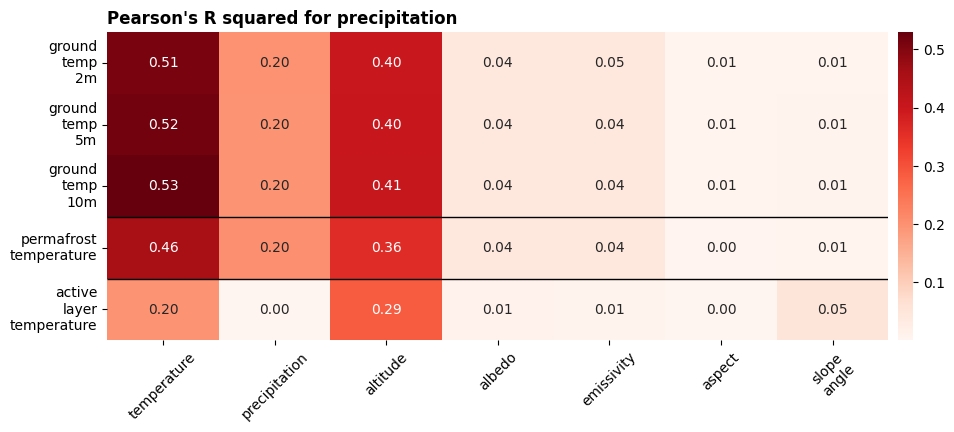

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

ax = sns.heatmap(
    data=df_spatial,
    annot=True,
    fmt='.2f',
    cmap='Reds',
    ax=ax,
    cbar_kws={'pad': 0.01}
)

# ax.vlines([1, 2, 6], *ax.get_ylim(), color='k')
ax.hlines([3, 4], *ax.get_xlim(), color='k', lw=1)

ax.set_title("Pearson's R squared for precipitation", loc='left', weight='bold')
plt.xticks(rotation=45, ha='center')
plt.show()